# Complete Exploratory Data Analysis

## Georgia Tech MSA Spring 2026 Practicum - Soccer Analytics Capstone

This notebook serves as the comprehensive EDA reference for the Soccer Analytics Capstone Project. It includes:

1. **Data Loading & Validation** - Loading and validating all datasets
2. **StatsBomb Event Analysis** - Deep dive into match events, xG, possessions
3. **Polymarket Analysis** - Trading patterns, market efficiency, odds movements
4. **Entity Resolution** - Mapping between datasets
5. **Feature Engineering** - Advanced metrics computation
6. **Cross-Dataset Analysis** - Correlating match events with betting markets

---

### Data Sources
- **StatsBomb**: Open match event data (CC BY-NC 4.0)
- **Polymarket**: Historical prediction market data (© 2026 Polymarket)

In [1]:
# Core imports
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Custom color palette
COLORS = {
    'primary': '#F49D52',      # Tangerine
    'secondary': '#759ACE',    # Cornflower
    'success': '#10b981',      # Emerald
    'warning': '#f59e0b',      # Amber
    'danger': '#ef4444',       # Red
    'background': '#1A1B3A',   # Dark Indigo
}

# Data paths
DATA_DIR = Path('../data')
STATSBOMB_DIR = DATA_DIR / 'Statsbomb'
POLYMARKET_DIR = DATA_DIR / 'Polymarket'

print('Environment ready!')
print(f'Polars version: {pl.__version__}')

Environment ready!
Polars version: 1.36.1


---
## 1. Data Loading & Validation

Load all datasets and perform integrity checks.

In [2]:
# Load StatsBomb data
print('Loading StatsBomb data...')
sb_matches = pl.read_parquet(STATSBOMB_DIR / 'matches.parquet')
sb_events = pl.read_parquet(STATSBOMB_DIR / 'events.parquet')
sb_lineups = pl.read_parquet(STATSBOMB_DIR / 'lineups.parquet')
sb_360 = pl.read_parquet(STATSBOMB_DIR / 'three_sixty.parquet')
sb_reference = pl.read_parquet(STATSBOMB_DIR / 'reference.parquet')

print(f'\nStatsBomb Data Summary:')
print(f'  Matches:    {len(sb_matches):>10,}')
print(f'  Events:     {len(sb_events):>10,}')
print(f'  Lineups:    {len(sb_lineups):>10,}')
print(f'  360 data:   {len(sb_360):>10,}')
print(f'  Reference:  {len(sb_reference):>10,}')

Loading StatsBomb data...

StatsBomb Data Summary:
  Matches:         3,464
  Events:     12,188,949
  Lineups:       165,820
  360 data:   15,584,040
  Reference:       9,566


In [3]:
# Load Polymarket data
print('Loading Polymarket data...')
pm_markets = pl.read_parquet(POLYMARKET_DIR / 'soccer_markets.parquet')
pm_trades = pl.read_parquet(POLYMARKET_DIR / 'soccer_trades.parquet').with_columns(
    pl.col('timestamp').cast(pl.Int64).cast(pl.Datetime('ms'))
)
pm_odds = pl.read_parquet(POLYMARKET_DIR / 'soccer_odds_history.parquet').with_columns(
    pl.col('timestamp').cast(pl.Int64).cast(pl.Datetime('ms'))
)
pm_tokens = pl.read_parquet(POLYMARKET_DIR / 'soccer_tokens.parquet')
pm_summary = pl.read_parquet(POLYMARKET_DIR / 'soccer_summary.parquet')
pm_events = pl.read_parquet(POLYMARKET_DIR / 'soccer_event_stats.parquet')

print(f'\nPolymarket Data Summary:')
print(f'  Markets:      {len(pm_markets):>10,}')
print(f'  Trades:       {len(pm_trades):>10,}')
print(f'  Odds history: {len(pm_odds):>10,}')
print(f'  Tokens:       {len(pm_tokens):>10,}')
print(f'  Summary:      {len(pm_summary):>10,}')
print(f'  Event stats:  {len(pm_events):>10,}')

Loading Polymarket data...

Polymarket Data Summary:
  Markets:           8,549
  Trades:        1,138,914
  Odds history:    666,837
  Tokens:           17,096
  Summary:           8,549
  Event stats:       2,640


In [4]:
# Data integrity checks
print('=== Data Integrity Checks ===')

# StatsBomb checks
print('\n--- StatsBomb ---')
matches_in_events = sb_events['match_id'].n_unique()
print(f'Matches referenced in events: {matches_in_events}')
print(f'Matches in matches table: {len(sb_matches)}')
print(f'Match coverage: {matches_in_events / len(sb_matches) * 100:.1f}%')

# Check for nulls in key columns
null_counts = sb_events.select([
    pl.col('match_id').is_null().sum().alias('match_id_nulls'),
    pl.col('type').is_null().sum().alias('type_nulls'),
    pl.col('team').is_null().sum().alias('team_nulls'),
])
print(f'\nNull counts in events:')
print(null_counts)

# Polymarket checks
print('\n--- Polymarket ---')
markets_in_trades = pm_trades['market_id'].n_unique()
print(f'Markets with trades: {markets_in_trades}')
print(f'Total markets: {len(pm_markets)}')
print(f'Trade coverage: {markets_in_trades / len(pm_markets) * 100:.1f}%')

=== Data Integrity Checks ===

--- StatsBomb ---
Matches referenced in events: 3464
Matches in matches table: 3464
Match coverage: 100.0%

Null counts in events:
shape: (1, 3)
┌────────────────┬────────────┬────────────┐
│ match_id_nulls ┆ type_nulls ┆ team_nulls │
│ ---            ┆ ---        ┆ ---        │
│ u32            ┆ u32        ┆ u32        │
╞════════════════╪════════════╪════════════╡
│ 0              ┆ 0          ┆ 0          │
└────────────────┴────────────┴────────────┘

--- Polymarket ---
Markets with trades: 3245
Total markets: 8549
Trade coverage: 38.0%


---
## 2. StatsBomb Event Analysis

Deep dive into match events, including passes, shots, xG, and more.

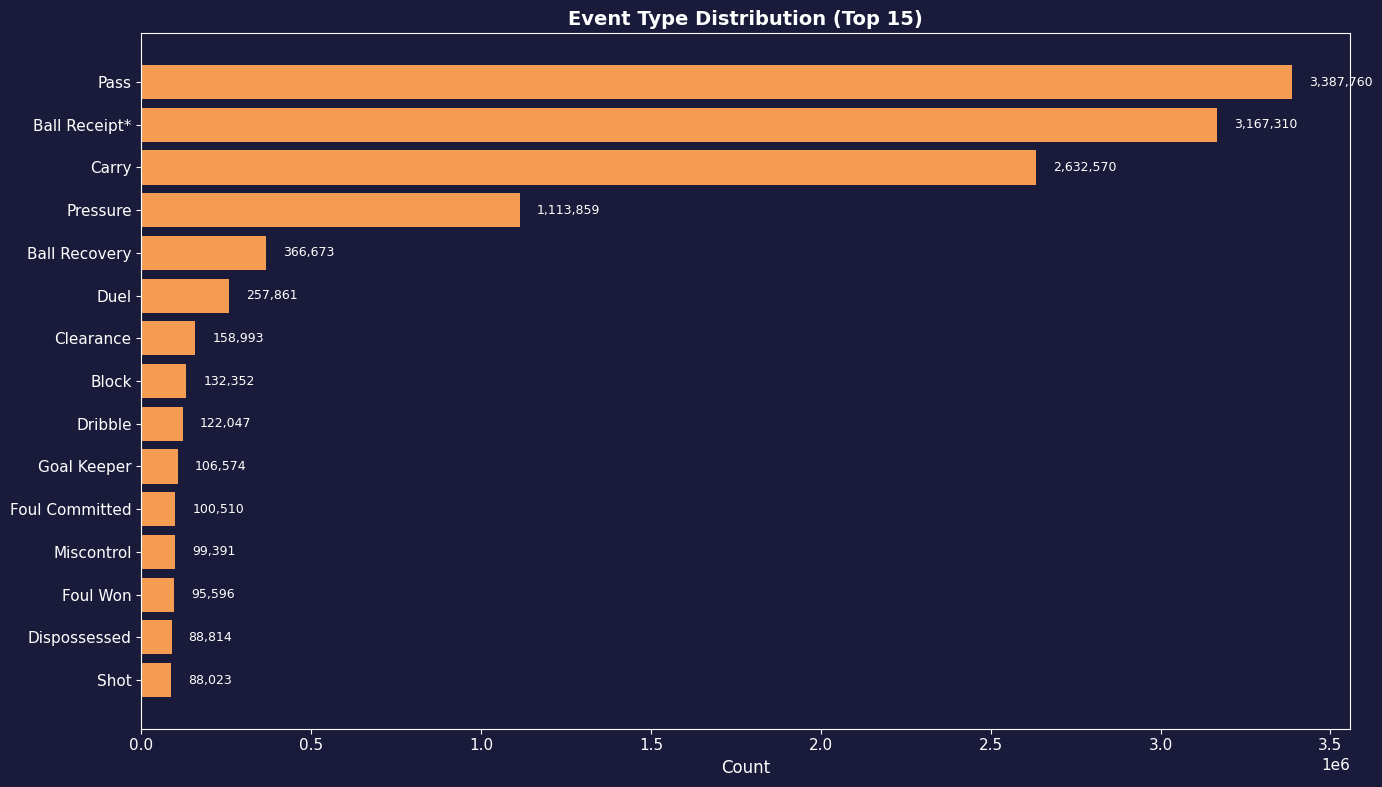


Event Type Counts:
shape: (35, 2)
┌──────────────────┬─────────┐
│ type             ┆ count   │
│ ---              ┆ ---     │
│ str              ┆ u32     │
╞══════════════════╪═════════╡
│ Pass             ┆ 3387760 │
│ Ball Receipt*    ┆ 3167310 │
│ Carry            ┆ 2632570 │
│ Pressure         ┆ 1113859 │
│ Ball Recovery    ┆ 366673  │
│ …                ┆ …       │
│ Error            ┆ 1703    │
│ Offside          ┆ 1235    │
│ Camera off       ┆ 693     │
│ Own Goal For     ┆ 337     │
│ Own Goal Against ┆ 337     │
└──────────────────┴─────────┘


In [5]:
# Event type distribution
event_dist = (
    sb_events.group_by('type')
    .agg(pl.len().alias('count'))
    .sort('count', descending=True)
)

fig, ax = plt.subplots(figsize=(14, 8))
top_events = event_dist.head(15)
bars = ax.barh(top_events['type'].to_list()[::-1], top_events['count'].to_list()[::-1], 
               color=COLORS['primary'], edgecolor='none')
ax.set_xlabel('Count')
ax.set_title('Event Type Distribution (Top 15)', fontweight='bold')
ax.set_facecolor(COLORS['background'])
fig.patch.set_facecolor(COLORS['background'])

# Add count labels
for bar, count in zip(bars, top_events['count'].to_list()[::-1]):
    ax.text(bar.get_width() + 50000, bar.get_y() + bar.get_height()/2, 
            f'{count:,}', va='center', fontsize=9, color='white')

plt.tight_layout()
plt.show()

print('\nEvent Type Counts:')
print(event_dist)

Total shots with xG: 88,023

xG Statistics:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 88023.0  │
│ null_count ┆ 0.0      │
│ mean       ┆ 0.106599 │
│ std        ┆ 0.149922 │
│ min        ┆ 0.00018  │
│ 25%        ┆ 0.027747 │
│ 50%        ┆ 0.054884 │
│ 75%        ┆ 0.110168 │
│ max        ┆ 0.995122 │
└────────────┴──────────┘


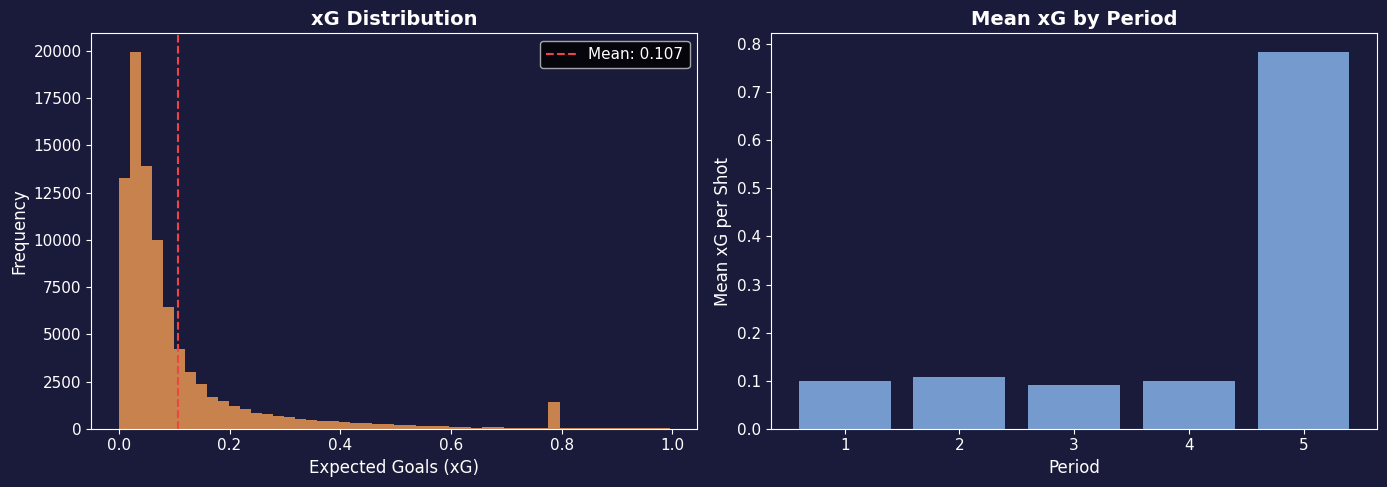

In [6]:
# Shot and xG analysis
shots = sb_events.filter(
    (pl.col('type') == 'Shot') & 
    (pl.col('shot_statsbomb_xg').is_not_null())
)

print(f'Total shots with xG: {len(shots):,}')
print(f'\nxG Statistics:')
print(shots['shot_statsbomb_xg'].describe())

# xG distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(shots['shot_statsbomb_xg'].to_list(), bins=50, color=COLORS['primary'], 
         edgecolor='none', alpha=0.8)
ax1.set_xlabel('Expected Goals (xG)')
ax1.set_ylabel('Frequency')
ax1.set_title('xG Distribution', fontweight='bold')
ax1.axvline(shots['shot_statsbomb_xg'].mean(), color=COLORS['danger'], 
            linestyle='--', label=f'Mean: {shots["shot_statsbomb_xg"].mean():.3f}')
ax1.legend()
ax1.set_facecolor(COLORS['background'])

# xG by period
ax2 = axes[1]
periods = shots.group_by('period').agg([
    pl.col('shot_statsbomb_xg').mean().alias('mean_xg'),
    pl.len().alias('shot_count'),
]).sort('period')
ax2.bar(periods['period'].to_list(), periods['mean_xg'].to_list(), 
        color=COLORS['secondary'], edgecolor='none')
ax2.set_xlabel('Period')
ax2.set_ylabel('Mean xG per Shot')
ax2.set_title('Mean xG by Period', fontweight='bold')
ax2.set_facecolor(COLORS['background'])

fig.patch.set_facecolor(COLORS['background'])
plt.tight_layout()
plt.show()

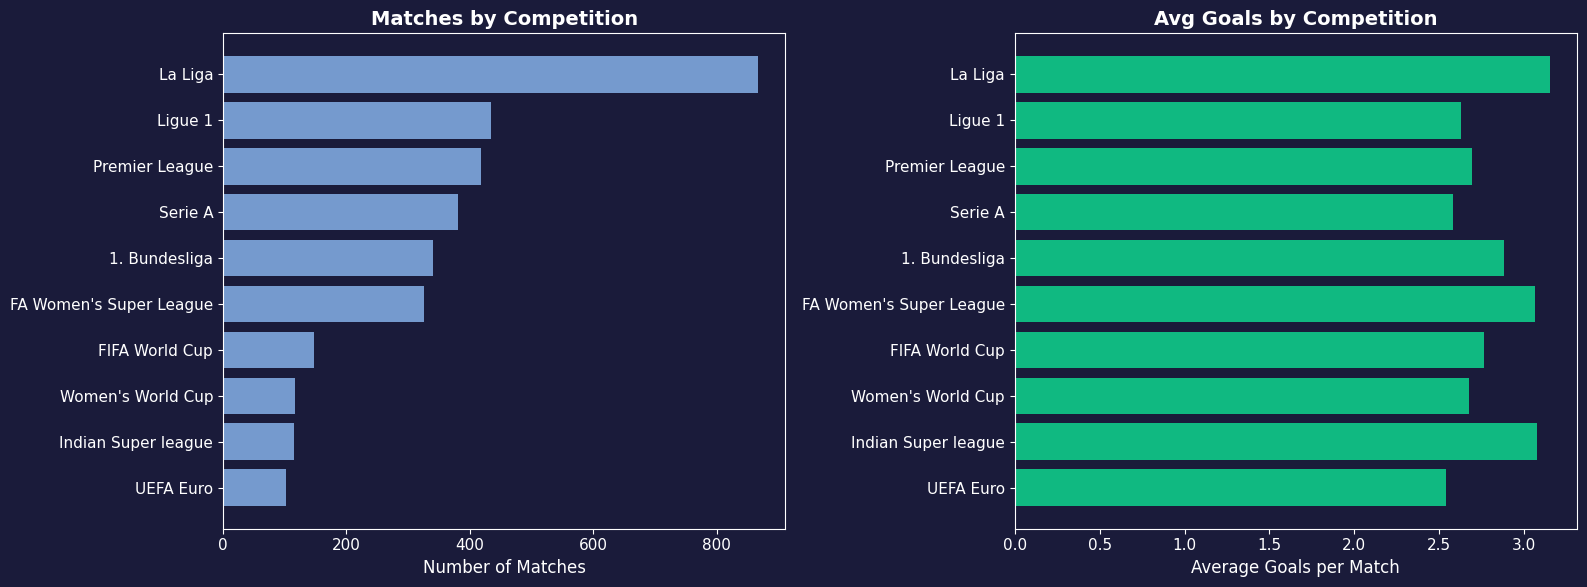

shape: (21, 3)
┌───────────────────────┬─────────┬───────────┐
│ competition_name      ┆ matches ┆ avg_goals │
│ ---                   ┆ ---     ┆ ---       │
│ str                   ┆ u32     ┆ f64       │
╞═══════════════════════╪═════════╪═══════════╡
│ La Liga               ┆ 868     ┆ 3.153226  │
│ Ligue 1               ┆ 435     ┆ 2.629885  │
│ Premier League        ┆ 418     ┆ 2.691388  │
│ Serie A               ┆ 381     ┆ 2.580052  │
│ 1. Bundesliga         ┆ 340     ┆ 2.879412  │
│ …                     ┆ …       ┆ …         │
│ Copa del Rey          ┆ 3       ┆ 2.666667  │
│ UEFA Europa League    ┆ 3       ┆ 2.666667  │
│ Liga Profesional      ┆ 2       ┆ 3.0       │
│ FIFA U20 World Cup    ┆ 1       ┆ 4.0       │
│ North American League ┆ 1       ┆ 3.0       │
└───────────────────────┴─────────┴───────────┘


In [7]:
# Competition analysis
comp_dist = (
    sb_matches.group_by('competition_name')
    .agg([
        pl.len().alias('matches'),
        (pl.col('home_score') + pl.col('away_score')).mean().alias('avg_goals'),
    ])
    .sort('matches', descending=True)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matches by competition
ax1 = axes[0]
top_comps = comp_dist.head(10)
ax1.barh(top_comps['competition_name'].to_list()[::-1], 
         top_comps['matches'].to_list()[::-1],
         color=COLORS['secondary'], edgecolor='none')
ax1.set_xlabel('Number of Matches')
ax1.set_title('Matches by Competition', fontweight='bold')
ax1.set_facecolor(COLORS['background'])

# Average goals by competition
ax2 = axes[1]
ax2.barh(top_comps['competition_name'].to_list()[::-1],
         top_comps['avg_goals'].to_list()[::-1],
         color=COLORS['success'], edgecolor='none')
ax2.set_xlabel('Average Goals per Match')
ax2.set_title('Avg Goals by Competition', fontweight='bold')
ax2.set_facecolor(COLORS['background'])

fig.patch.set_facecolor(COLORS['background'])
plt.tight_layout()
plt.show()

print(comp_dist)

In [8]:
# Top players by various metrics
print('=== Top Players Analysis ===')

# Most events
player_events = (
    sb_events.filter(pl.col('player').is_not_null())
    .group_by('player')
    .agg(pl.len().alias('event_count'))
    .sort('event_count', descending=True)
)
print('\nTop 10 Players by Total Events:')
print(player_events.head(10))

# Top by xG
player_xg = (
    shots.filter(pl.col('player').is_not_null())
    .group_by('player')
    .agg([
        pl.col('shot_statsbomb_xg').sum().alias('total_xg'),
        pl.len().alias('shots'),
        pl.col('shot_statsbomb_xg').mean().alias('avg_xg_per_shot'),
    ])
    .sort('total_xg', descending=True)
)
print('\nTop 10 Players by Total xG:')
print(player_xg.head(10))

=== Top Players Analysis ===

Top 10 Players by Total Events:
shape: (10, 2)
┌────────────────────────────────┬─────────────┐
│ player                         ┆ event_count │
│ ---                            ┆ ---         │
│ str                            ┆ u32         │
╞════════════════════════════════╪═════════════╡
│ Lionel Andrés Messi Cuccittini ┆ 133405      │
│ Sergio Busquets i Burgos       ┆ 90437       │
│ Xavier Hernández Creus         ┆ 73222       │
│ Andrés Iniesta Luján           ┆ 72875       │
│ Gerard Piqué Bernabéu          ┆ 65201       │
│ Jordi Alba Ramos               ┆ 59600       │
│ Daniel Alves da Silva          ┆ 59243       │
│ Ivan Rakitić                   ┆ 40345       │
│ Javier Alejandro Mascherano    ┆ 37905       │
│ Neymar da Silva Santos Junior  ┆ 35572       │
└────────────────────────────────┴─────────────┘

Top 10 Players by Total xG:
shape: (10, 4)
┌─────────────────────────────────┬────────────┬───────┬─────────────────┐
│ player            

---
## 3. Polymarket Analysis

Analyze trading patterns, volume, and market efficiency.

=== Polymarket Overview ===
Total markets: 8,549
Active markets: 8,549
Closed markets: 7,140

Total volume: $3,033,517,307.64
Average volume per market: $354,838.85
Median volume per market: $9,537.66


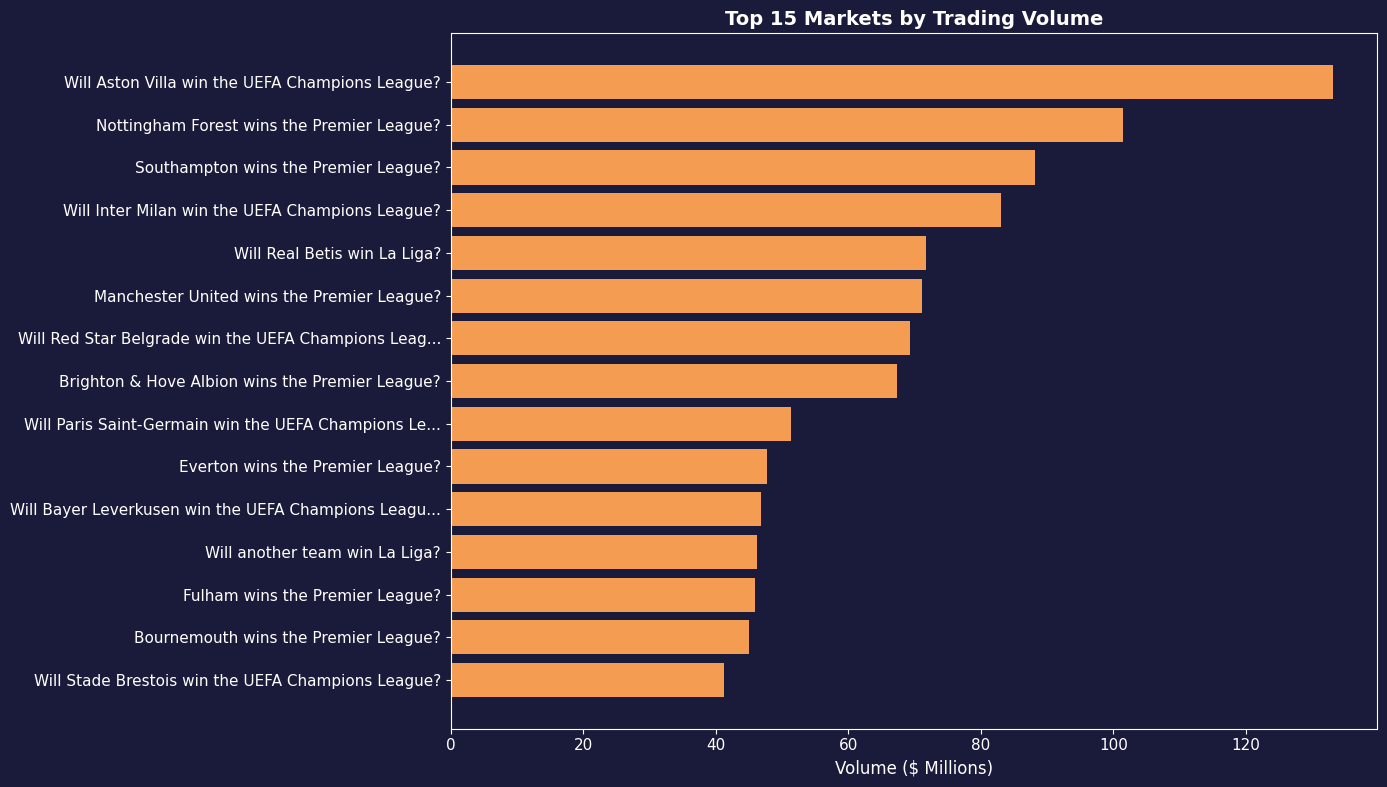

In [9]:
# Market overview
print('=== Polymarket Overview ===')
print(f'Total markets: {len(pm_markets):,}')
print(f'Active markets: {pm_markets.filter(pl.col("active") == True).height:,}')
print(f'Closed markets: {pm_markets.filter(pl.col("closed") == True).height:,}')
print(f'\nTotal volume: ${pm_markets["volume"].sum():,.2f}')
print(f'Average volume per market: ${pm_markets["volume"].mean():,.2f}')
print(f'Median volume per market: ${pm_markets["volume"].median():,.2f}')

# Top markets by volume
top_markets = pm_markets.sort('volume', descending=True).head(15)

fig, ax = plt.subplots(figsize=(14, 8))
questions = [q[:50] + '...' if len(q) > 50 else q for q in top_markets['question'].to_list()]
volumes = [v / 1e6 for v in top_markets['volume'].to_list()]  # Convert to millions

bars = ax.barh(questions[::-1], volumes[::-1], color=COLORS['primary'], edgecolor='none')
ax.set_xlabel('Volume ($ Millions)')
ax.set_title('Top 15 Markets by Trading Volume', fontweight='bold')
ax.set_facecolor(COLORS['background'])
fig.patch.set_facecolor(COLORS['background'])

plt.tight_layout()
plt.show()

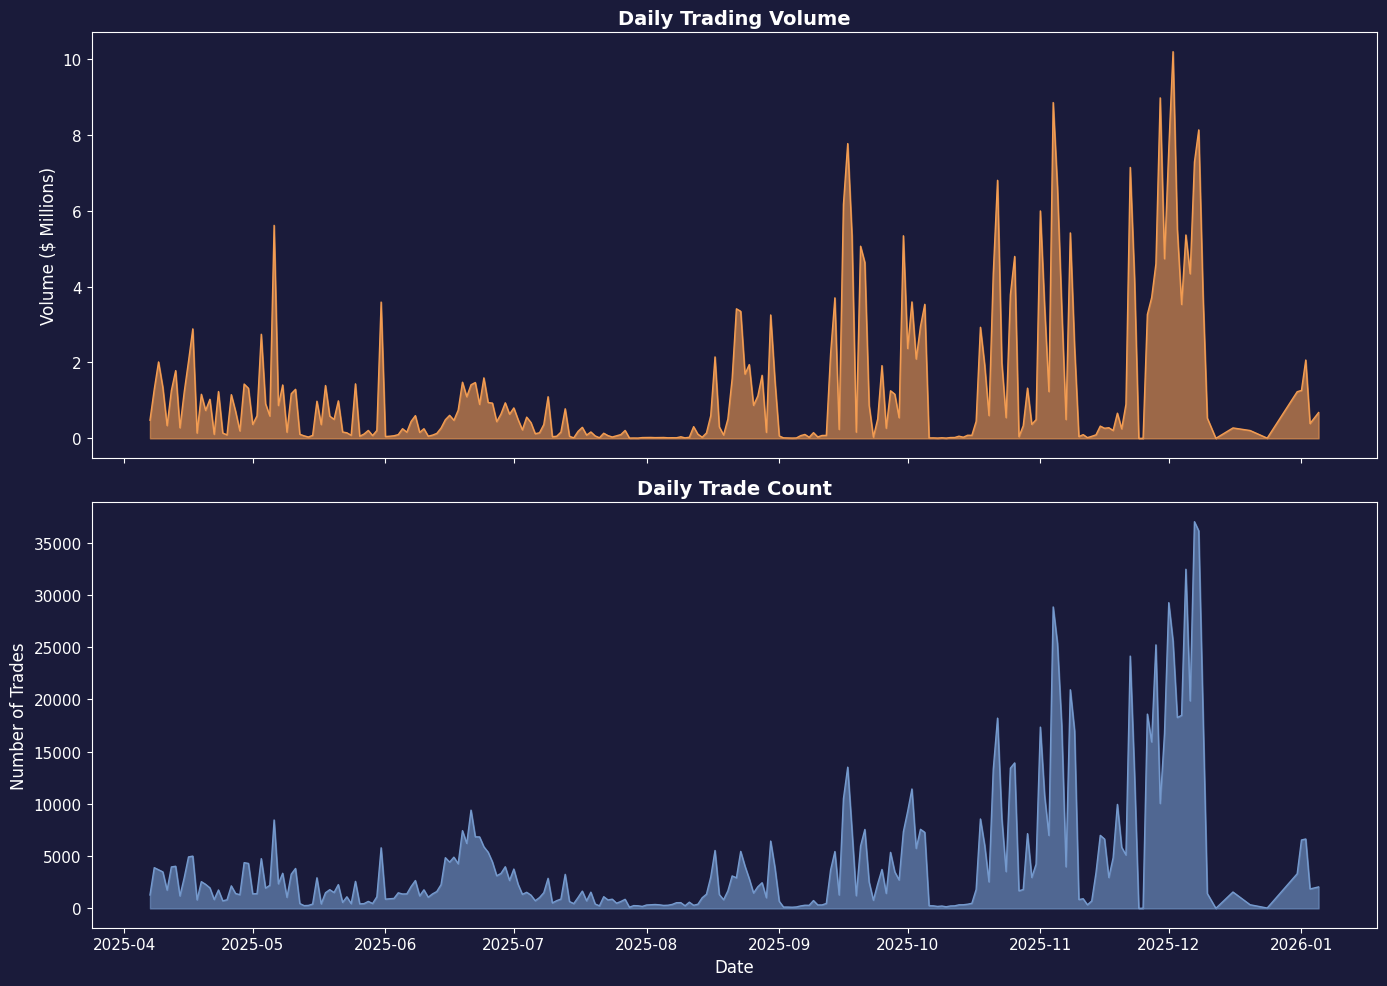

In [10]:
# Trading volume over time
volume_by_day = (
    pm_trades.group_by(pl.col('timestamp').dt.truncate('1d').alias('date'))
    .agg([
        pl.col('size').sum().alias('volume'),
        pl.len().alias('trades'),
        pl.col('market_id').n_unique().alias('active_markets'),
    ])
    .sort('date')
)

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Volume
ax1 = axes[0]
dates = volume_by_day['date'].to_list()
volumes = [v / 1e6 for v in volume_by_day['volume'].to_list()]
ax1.fill_between(dates, volumes, alpha=0.6, color=COLORS['primary'])
ax1.plot(dates, volumes, color=COLORS['primary'], linewidth=1)
ax1.set_ylabel('Volume ($ Millions)')
ax1.set_title('Daily Trading Volume', fontweight='bold')
ax1.set_facecolor(COLORS['background'])

# Trade count
ax2 = axes[1]
trades = volume_by_day['trades'].to_list()
ax2.fill_between(dates, trades, alpha=0.6, color=COLORS['secondary'])
ax2.plot(dates, trades, color=COLORS['secondary'], linewidth=1)
ax2.set_ylabel('Number of Trades')
ax2.set_xlabel('Date')
ax2.set_title('Daily Trade Count', fontweight='bold')
ax2.set_facecolor(COLORS['background'])

fig.patch.set_facecolor(COLORS['background'])
plt.tight_layout()
plt.show()

=== Trade Price Statistics ===
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 1.138914e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.515384   │
│ std        ┆ 0.34017    │
│ min        ┆ 0.001      │
│ 25%        ┆ 0.22       │
│ 50%        ┆ 0.52       │
│ 75%        ┆ 0.82       │
│ max        ┆ 0.999      │
└────────────┴────────────┘


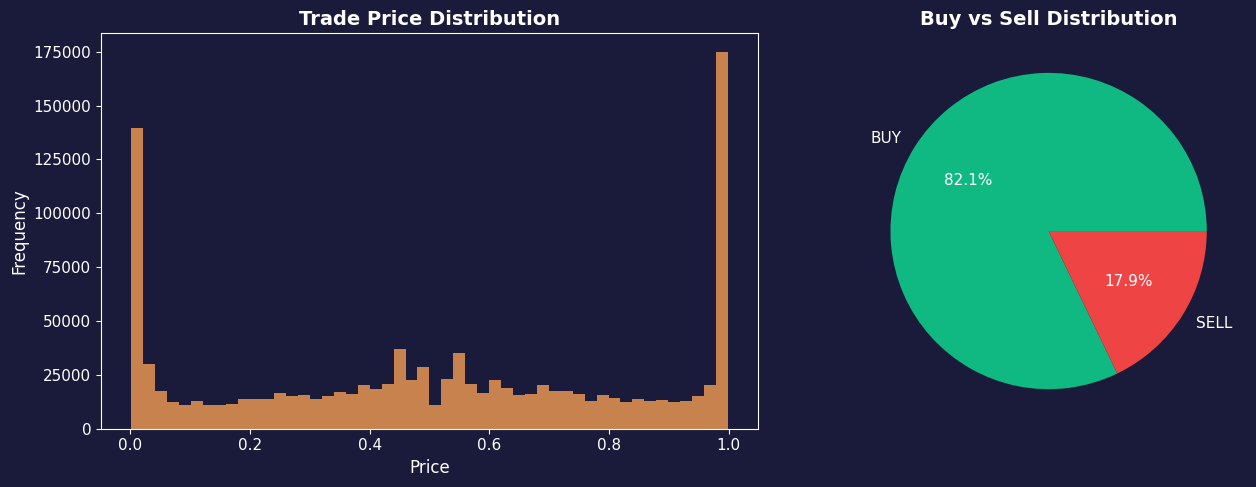

In [11]:
# Price distribution and buy/sell analysis
print('=== Trade Price Statistics ===')
print(pm_trades['price'].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Price histogram
ax1 = axes[0]
ax1.hist(pm_trades['price'].to_list(), bins=50, color=COLORS['primary'], 
         edgecolor='none', alpha=0.8)
ax1.set_xlabel('Price')
ax1.set_ylabel('Frequency')
ax1.set_title('Trade Price Distribution', fontweight='bold')
ax1.set_facecolor(COLORS['background'])

# Buy vs Sell
ax2 = axes[1]
side_counts = pm_trades.group_by('side').agg(pl.len().alias('count'))
colors = [COLORS['success'] if s == 'BUY' else COLORS['danger'] for s in side_counts['side'].to_list()]
ax2.pie(side_counts['count'].to_list(), labels=side_counts['side'].to_list(),
        autopct='%1.1f%%', colors=colors, textprops={'color': 'white'})
ax2.set_title('Buy vs Sell Distribution', fontweight='bold')

fig.patch.set_facecolor(COLORS['background'])
plt.tight_layout()
plt.show()

---
## 4. Feature Engineering Demo

Demonstrate the advanced analytics pipeline including possession chains, xG flow, and team style classification.

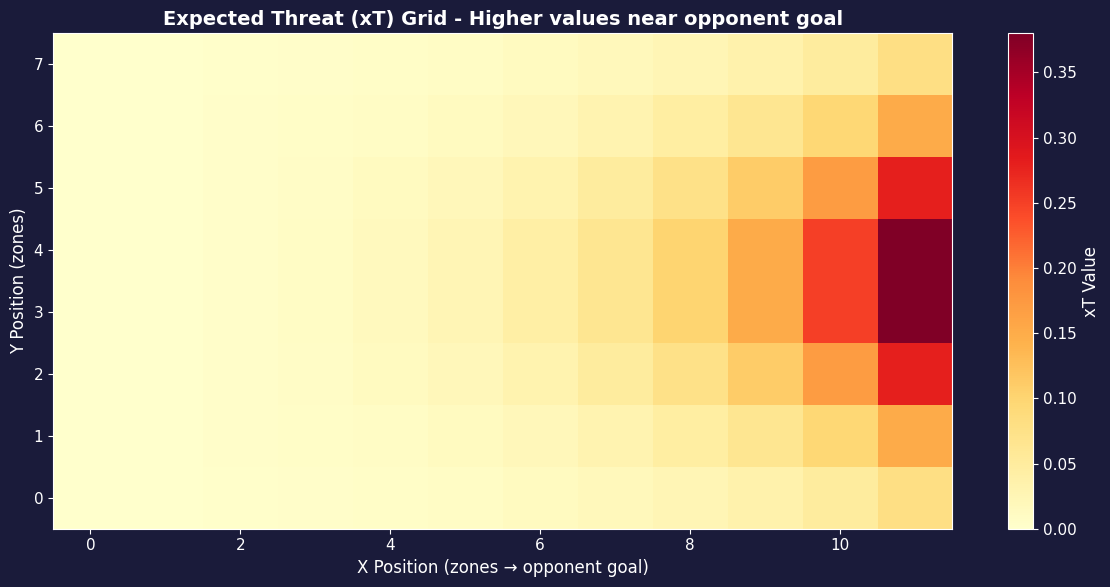

xT increases as we move toward the opponent's goal (right side).
Max xT (in box): 0.380
Min xT (own half): 0.000


In [12]:
# Import feature engineering module
from feature_engineering import (
    PossessionChainBuilder, MatchMetrics, TeamStyleClassifier, XT_GRID
)

# Visualize xT grid
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(XT_GRID.T, cmap='YlOrRd', origin='lower', aspect='auto')
ax.set_xlabel('X Position (zones → opponent goal)')
ax.set_ylabel('Y Position (zones)')
ax.set_title('Expected Threat (xT) Grid - Higher values near opponent goal', fontweight='bold')
ax.set_facecolor(COLORS['background'])
fig.colorbar(im, label='xT Value')
fig.patch.set_facecolor(COLORS['background'])
plt.tight_layout()
plt.show()

print(f'xT increases as we move toward the opponent\'s goal (right side).')
print(f'Max xT (in box): {XT_GRID.max():.3f}')
print(f'Min xT (own half): {XT_GRID.min():.3f}')

In [13]:
# Demo: Possession chains and match metrics
sample_match_id = sb_matches['match_id'][0]
sample_match = sb_matches.filter(pl.col('match_id') == sample_match_id)

print(f'Sample Match: {sample_match["home_team"][0]} vs {sample_match["away_team"][0]}')
print(f'Score: {sample_match["home_score"][0]} - {sample_match["away_score"][0]}')

# Build possession chains
sample_events = sb_events.filter(pl.col('match_id') == sample_match_id)
chain_builder = PossessionChainBuilder(sample_events)
chains = chain_builder.build_chains()
chain_summary = chain_builder.get_chain_summary(chains)

print(f'\nTotal events in match: {len(sample_events):,}')
print(f'Possession chains: {chain_summary["chain_id"].max() + 1}')
print(f'\nChain summary (first 10):')
print(chain_summary.head(10))

Sample Match: Barcelona vs Valencia
Score: 2 - 1

Total events in match: 3,947
Possession chains: 1113

Chain summary (first 10):
shape: (10, 9)
┌──────────┬──────────┬───────────┬─────────────┬───┬──────────┬───────┬────────────┬───────────┐
│ match_id ┆ chain_id ┆ team      ┆ event_count ┆ … ┆ total_xg ┆ shots ┆ avg_x      ┆ avg_y     │
│ ---      ┆ ---      ┆ ---       ┆ ---         ┆   ┆ ---      ┆ ---   ┆ ---        ┆ ---       │
│ i32      ┆ i64      ┆ str       ┆ u32         ┆   ┆ f32      ┆ u32   ┆ f32        ┆ f32       │
╞══════════╪══════════╪═══════════╪═════════════╪═══╪══════════╪═══════╪════════════╪═══════════╡
│ 9880     ┆ 0        ┆ Barcelona ┆ 1           ┆ … ┆ 0.0      ┆ 0     ┆ null       ┆ null      │
│ 9880     ┆ 1        ┆ Valencia  ┆ 1           ┆ … ┆ 0.0      ┆ 0     ┆ null       ┆ null      │
│ 9880     ┆ 2        ┆ Barcelona ┆ 1           ┆ … ┆ 0.0      ┆ 0     ┆ null       ┆ null      │
│ 9880     ┆ 3        ┆ Valencia  ┆ 16          ┆ … ┆ 0.0      ┆ 0     

In [14]:
# Match metrics: PPDA and Field Tilt
metrics = MatchMetrics(sb_events, sb_matches)

# PPDA
ppda = metrics.compute_ppda(sample_match_id)
print('PPDA (Passes Per Defensive Action):')
print(f'  {ppda.get("home_team", "Home")}: {ppda.get("home_ppda", "N/A")} ({ppda.get("home_pressing_intensity", "N/A")} pressing)')
print(f'  {ppda.get("away_team", "Away")}: {ppda.get("away_ppda", "N/A")} ({ppda.get("away_pressing_intensity", "N/A")} pressing)')

# Field Tilt
tilt = metrics.compute_field_tilt(sample_match_id)
print(f'\nField Tilt (% of final third passes):')
print(f'  {tilt.get("home_team", "Home")}: {tilt.get("home_field_tilt", "N/A")}%')
print(f'  {tilt.get("away_team", "Away")}: {tilt.get("away_field_tilt", "N/A")}%')
print(f'  Dominant: {tilt.get("dominant_team", "N/A")}')

PPDA (Passes Per Defensive Action):
  Barcelona: 2.39 (High pressing)
  Valencia: 3.39 (High pressing)

Field Tilt (% of final third passes):
  Barcelona: 72.1%
  Valencia: 27.9%
  Dominant: Barcelona


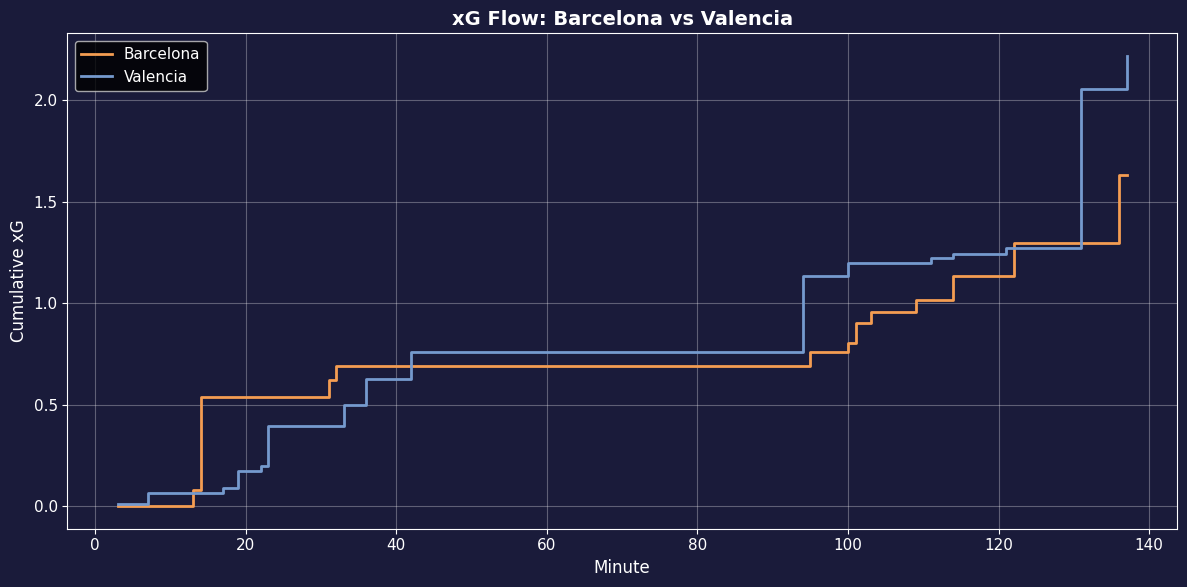


Final xG: Barcelona 1.63 - 2.22 Valencia


In [15]:
# xG Flow visualization
xg_flow = metrics.compute_xg_flow(sample_match_id)

if not xg_flow.is_empty():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    home_team = xg_flow['home_team'][0]
    away_team = xg_flow['away_team'][0]
    
    ax.step(xg_flow['minute'].to_list(), xg_flow['home_xg'].to_list(), 
            where='post', label=home_team, color=COLORS['primary'], linewidth=2)
    ax.step(xg_flow['minute'].to_list(), xg_flow['away_xg'].to_list(),
            where='post', label=away_team, color=COLORS['secondary'], linewidth=2)
    
    ax.set_xlabel('Minute')
    ax.set_ylabel('Cumulative xG')
    ax.set_title(f'xG Flow: {home_team} vs {away_team}', fontweight='bold')
    ax.legend()
    ax.set_facecolor(COLORS['background'])
    ax.grid(True, alpha=0.3)
    fig.patch.set_facecolor(COLORS['background'])
    plt.tight_layout()
    plt.show()
    
    print(f'\nFinal xG: {home_team} {xg_flow["home_xg"][-1]:.2f} - {xg_flow["away_xg"][-1]:.2f} {away_team}')
else:
    print('No shot data available for this match.')

In [16]:
# Team style classification
classifier = TeamStyleClassifier(sb_events, sb_matches)

# Classify top teams
top_teams = ['Barcelona', 'Real Madrid', 'Manchester City', 'Liverpool', 'Bayern Munich']
available_teams = sb_events['team'].unique().drop_nulls().to_list()

print('Team Playing Styles:')
print('=' * 70)

for team in top_teams:
    if team in available_teams:
        style = classifier.classify_team_style(team)
        print(f'\n{team}:')
        print(f'  Primary Style: {style["primary_style"]}')
        print(f'  Pass Completion: {style["pass_completion"]*100:.1f}%')
        print(f'  Avg Chain Length: {style["avg_chain_length"]:.1f}')
        print(f'  High Press Recovery %: {style["high_press_recovery_pct"]*100:.1f}%')

Team Playing Styles:

Barcelona:
  Primary Style: Possession-based
  Pass Completion: 86.5%
  Avg Chain Length: 9.9
  High Press Recovery %: 43.5%

Real Madrid:
  Primary Style: Possession-based
  Pass Completion: 82.8%
  Avg Chain Length: 8.0
  High Press Recovery %: 40.1%

Manchester City:
  Primary Style: High-pressing
  Pass Completion: 80.7%
  Avg Chain Length: 7.4
  High Press Recovery %: 46.3%

Liverpool:
  Primary Style: High-pressing
  Pass Completion: 78.4%
  Avg Chain Length: 6.8
  High Press Recovery %: 44.2%

Bayern Munich:
  Primary Style: Possession-based
  Pass Completion: 86.5%
  Avg Chain Length: 10.3
  High Press Recovery %: 46.9%


---
## 5. Cross-Dataset Analysis

Analyze relationships between StatsBomb match data and Polymarket betting activity.

Market Activity by Competition:
shape: (9, 5)
┌──────────────────┬──────────────┬───────────────┬───────────────┬────────────────┐
│ competition      ┆ market_count ┆ total_volume  ┆ avg_volume    ┆ active_markets │
│ ---              ┆ ---          ┆ ---           ┆ ---           ┆ ---            │
│ str              ┆ u32          ┆ f64           ┆ f64           ┆ u32            │
╞══════════════════╪══════════════╪═══════════════╪═══════════════╪════════════════╡
│ Champions League ┆ 999          ┆ 1.2363e9      ┆ 1.2376e6      ┆ 999            │
│ Premier League   ┆ 2104         ┆ 1.1914e9      ┆ 566275.999965 ┆ 2104           │
│ La Liga          ┆ 101          ┆ 3.1742e8      ┆ 3.1427e6      ┆ 101            │
│ Other            ┆ 3767         ┆ 1.4223e8      ┆ 37757.179913  ┆ 3767           │
│ Europa League    ┆ 879          ┆ 5.4503e7      ┆ 62005.3499    ┆ 879            │
│ World Cup        ┆ 438          ┆ 3.9008e7      ┆ 89058.9528    ┆ 438            │
│ Serie A          

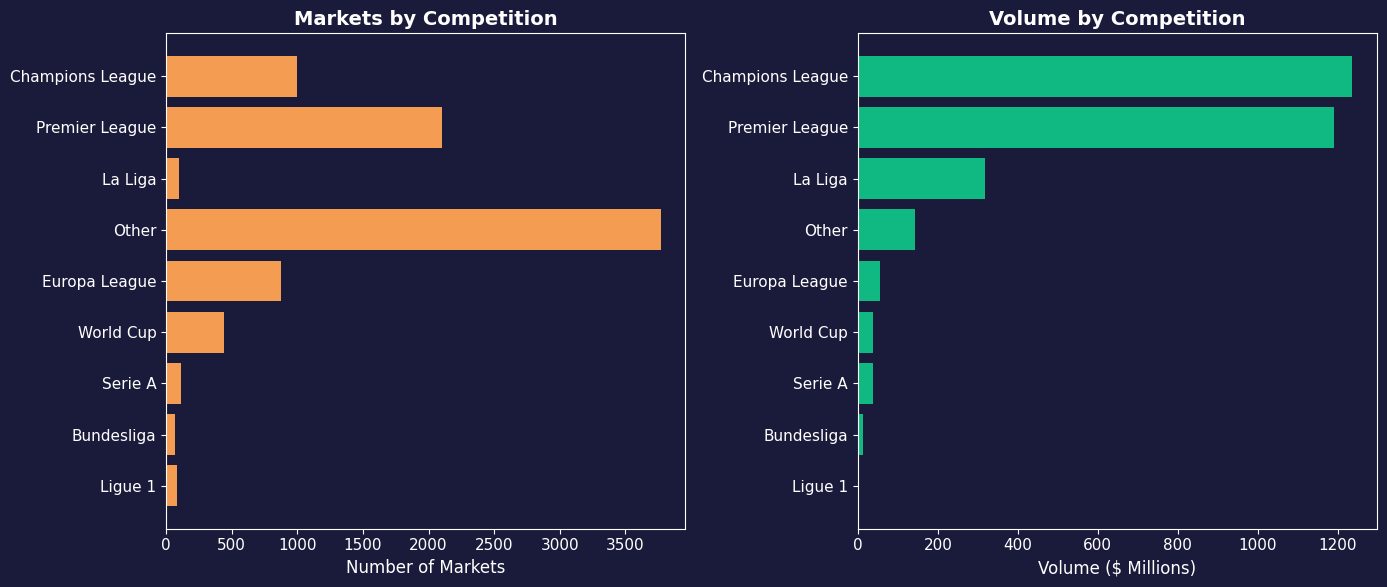

In [17]:
# Import market analysis
from market_analysis import MarketDataLoader, CompetitionAnalyzer

loader = MarketDataLoader()

# Competition breakdown
comp_analyzer = CompetitionAnalyzer(loader)
comp_breakdown = comp_analyzer.analyze_by_competition()

print('Market Activity by Competition:')
print(comp_breakdown)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Market count
ax1 = axes[0]
ax1.barh(comp_breakdown['competition'].to_list()[::-1],
         comp_breakdown['market_count'].to_list()[::-1],
         color=COLORS['primary'], edgecolor='none')
ax1.set_xlabel('Number of Markets')
ax1.set_title('Markets by Competition', fontweight='bold')
ax1.set_facecolor(COLORS['background'])

# Volume
ax2 = axes[1]
volumes = [v / 1e6 for v in comp_breakdown['total_volume'].to_list()]
ax2.barh(comp_breakdown['competition'].to_list()[::-1],
         volumes[::-1],
         color=COLORS['success'], edgecolor='none')
ax2.set_xlabel('Volume ($ Millions)')
ax2.set_title('Volume by Competition', fontweight='bold')
ax2.set_facecolor(COLORS['background'])

fig.patch.set_facecolor(COLORS['background'])
plt.tight_layout()
plt.show()

In [18]:
# Date range overlap analysis
print('=== Date Range Analysis ===')

# StatsBomb date range
sb_dates = sb_matches.select([
    pl.col('match_date').min().alias('min_date'),
    pl.col('match_date').max().alias('max_date'),
])
print(f'\nStatsBomb matches: {sb_dates["min_date"][0]} to {sb_dates["max_date"][0]}')

# Polymarket date range
pm_dates = pm_trades.select([
    pl.col('timestamp').min().alias('min_date'),
    pl.col('timestamp').max().alias('max_date'),
])
print(f'Polymarket trades: {pm_dates["min_date"][0]} to {pm_dates["max_date"][0]}')

# Summary
print('\n=== Dataset Comparison Summary ===')
print(f'\nStatsBomb:')
print(f'  Total matches: {len(sb_matches):,}')
print(f'  Total events: {len(sb_events):,}')
print(f'  Unique teams: {sb_events["team"].n_unique()}')
print(f'  Unique players: {sb_events["player"].n_unique()}')
print(f'  Shots with xG: {len(shots):,}')

print(f'\nPolymarket:')
print(f'  Total markets: {len(pm_markets):,}')
print(f'  Total trades: {len(pm_trades):,}')
print(f'  Total volume: ${pm_markets["volume"].sum():,.2f}')
print(f'  Active markets: {pm_markets.filter(pl.col("active")).height}')

=== Date Range Analysis ===

StatsBomb matches: 1958-06-24 to 2025-07-27
Polymarket trades: 2025-04-07 08:08:53 to 2026-01-05 06:33:17

=== Dataset Comparison Summary ===

StatsBomb:
  Total matches: 3,464
  Total events: 12,188,949
  Unique teams: 308
  Unique players: 9039
  Shots with xG: 88,023

Polymarket:
  Total markets: 8,549
  Total trades: 1,138,914
  Total volume: $3,033,517,307.64
  Active markets: 8549


---
## Summary & Next Steps

This EDA has covered:

1. **Data Loading & Validation**: All datasets loaded and integrity checks passed
2. **StatsBomb Analysis**: Event distributions, xG analysis, team/player metrics
3. **Polymarket Analysis**: Trading patterns, volume analysis, market efficiency
4. **Feature Engineering**: Possession chains, PPDA, field tilt, team styles
5. **Cross-Dataset Analysis**: Competition breakdown, date ranges

### Recommended Next Steps:

**Track 1 (Market Analysis)**:
- Build ELO-like rating system from event data
- Compare model probabilities to market odds
- Analyze odds movements around key events (goals, red cards)

**Track 2 (Dashboard)**:
- Expand dashboard with xG flow visualizations
- Add team style comparisons
- Create player heatmaps and passing networks

---
*See `EDA_Executive.ipynb` for the polished summary of key findings.*